# 多模型融合

In [3]:
import h5py
import numpy as np
import pandas as pd
from sklearn.utils import shuffle
from keras.models import *
from keras.layers import *
from keras.preprocessing.image import *
from keras.callbacks import *
import matplotlib.pyplot as plt
np.random.seed(2018)


/home/wson/anaconda3/envs/tf/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [4]:
def plot_history(history):
    # list all data in history
    # print(history.history.keys())
    # summarize history for accuracy
    plt.plot(history.history['acc'])
    plt.plot(history.history['val_acc'])
    plt.title('model accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.show()
    # summarize history for loss
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.show()

## 读取特征数据

* 使用80%数据作为训练集，20%数据作为验证集

In [5]:
def read_feature():
    h5_filelist = ["feature_Xception.h5", "feature_InceptionV3.h5", "feature_InceptionResNetV2.h5"]

    X_train = []
    X_test = []
    X_val = []
    X_test = []

    for filename in h5_filelist:
        with h5py.File(filename, 'r') as h:
            X_pretrain = np.array(h['pretrain'])
            y_pretrain = np.array(h['pretrain_label'])
            X_finetune = np.array(h['finetune'])
            y_finetune = np.array(h['finetune_label'])
            y_val = np.array(h['val_label'])
            X_val.append(np.array(h['val']))
            X_test.append(np.array(h['test']))
            
            X_train.append(np.concatenate((X_pretrain, X_finetune), axis=0))
            y_train = np.concatenate((y_pretrain, y_finetune), axis=0)

    X_train = np.concatenate(X_train, axis=1)
    X_val = np.concatenate(X_val, axis=1)
    X_test = np.concatenate(X_test, axis=1)

    X_train, y_train = shuffle(X_train, y_train)
    
    return X_train, y_train, X_val, y_val, X_test


In [6]:
X_train, y_train, X_val, y_val, X_test = read_feature()
print(X_train.shape, y_train.shape, X_val.shape, y_val.shape, X_test.shape)

(19916, 5632) (19916,) (4979, 5632) (4979,) (12500, 5632)


## 构建分类器

In [10]:
def build_model(input_shape, drop_prob: float, lr=1e-3, decay=1e-6):
    input_tensor = Input(input_shape)
    x = Dropout(drop_prob)(input_tensor)
    x = Dense(1, activation='sigmoid', name='top_sigmoid')(x)
    model = Model(input_tensor, x)

    opt = optimizers.Adam(lr=lr, decay=decay)
    model.compile(optimizer=opt, loss='binary_crossentropy', metrics=['accuracy'])
    
    return model

* 调整参数

In [6]:
model = build_model(X_train.shape[1:], 0.5, lr=1e-3, decay=1e-6)

In [7]:
callbacks = [EarlyStopping(monitor='val_loss', patience=5, verbose=0, mode='min'),
             ModelCheckpoint(filepath='top_multimodel.h5', monitor='val_loss', verbose=0, save_best_only=True)]

history = model.fit(X_train, y_train, batch_size=128, epochs=30, validation_data=(X_val, y_val), callbacks=callbacks)

Train on 19916 samples, validate on 4979 samples
Epoch 1/30
19916/19916 [==============================] - 3s 158us/step - loss: 0.0555 - acc: 0.9839 - val_loss: 0.0151 - val_acc: 0.9962
Epoch 2/30
19916/19916 [==============================] - 1s 56us/step - loss: 0.0141 - acc: 0.9961 - val_loss: 0.0094 - val_acc: 0.9984
Epoch 3/30
19916/19916 [==============================] - 1s 61us/step - loss: 0.0118 - acc: 0.9967 - val_loss: 0.0088 - val_acc: 0.9982
Epoch 4/30
19916/19916 [==============================] - 1s 54us/step - loss: 0.0106 - acc: 0.9969 - val_loss: 0.0074 - val_acc: 0.9984
Epoch 5/30
19916/19916 [==============================] - 1s 51us/step - loss: 0.0099 - acc: 0.9974 - val_loss: 0.0075 - val_acc: 0.9986
Epoch 6/30
19916/19916 [==============================] - 1s 53us/step - loss: 0.0085 - acc: 0.9975 - val_loss: 0.0067 - val_acc: 0.9986
Epoch 7/30
19916/19916 [==============================] - 1s 49us/step - loss: 0.0093 - acc: 0.9973 - val_loss: 0.0074 - val_acc

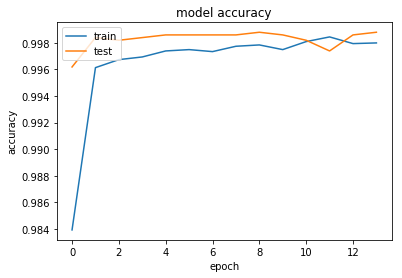

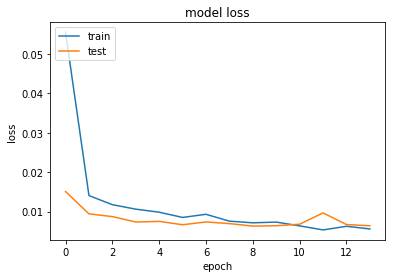

In [8]:
plot_history(history)

## 改进

In [2]:
from sklearn.model_selection import StratifiedKFold

In [7]:
X = np.concatenate((X_train, X_val), axis=0)
y = np.concatenate((y_train, y_val), axis=0)
print(X.shape, y.shape)

(24895, 5632) (24895,)


In [23]:
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=2018)

loss = 1.0
i = 1
for train, val in skf.split(X, y):
    print("fold %d:"%i)
    callbacks = [EarlyStopping(monitor='val_loss', patience=5, verbose=0, mode='min'),
                 ModelCheckpoint(filepath='top_multimodel.h5', monitor='val_loss', verbose=0, save_best_only=True)]
    model = build_model(X_train.shape[1:], 0.7, lr=1e-3, decay=1e-6)

    tmp_history = model.fit(X[train], y[train], batch_size=128, epochs=30, validation_data=(X[val], y[val]), callbacks=callbacks)
    
    model.load_weights('top_multimodel.h5')
    tmp_loss = model.evaluate(X[val], y[val], verbose=0)
    if tmp_loss[0] < loss:
        loss = tmp_loss[0]
        model.save('top_multimodel_final.h5')
        history = tmp_history
        print("save fold %d, loss %.4f."%(i, loss))
        
    i = i + 1

fold 1:
Train on 19916 samples, validate on 4979 samples
Epoch 1/30
19916/19916 [==============================] - 2s 88us/step - loss: 0.0612 - acc: 0.9818 - val_loss: 0.0160 - val_acc: 0.9958
Epoch 2/30
19916/19916 [==============================] - 1s 55us/step - loss: 0.0168 - acc: 0.9955 - val_loss: 0.0150 - val_acc: 0.9964
Epoch 3/30
19916/19916 [==============================] - 1s 55us/step - loss: 0.0131 - acc: 0.9969 - val_loss: 0.0117 - val_acc: 0.9966
Epoch 4/30
19916/19916 [==============================] - 1s 54us/step - loss: 0.0110 - acc: 0.9970 - val_loss: 0.0118 - val_acc: 0.9962
Epoch 5/30
19916/19916 [==============================] - 1s 68us/step - loss: 0.0106 - acc: 0.9973 - val_loss: 0.0117 - val_acc: 0.9964
Epoch 6/30
19916/19916 [==============================] - 1s 70us/step - loss: 0.0106 - acc: 0.9967 - val_loss: 0.0118 - val_acc: 0.9964
Epoch 7/30
19916/19916 [==============================] - 1s 56us/step - loss: 0.0096 - acc: 0.9973 - val_loss: 0.0124 - 

19916/19916 [==============================] - 1s 44us/step - loss: 0.0086 - acc: 0.9971 - val_loss: 0.0118 - val_acc: 0.9974


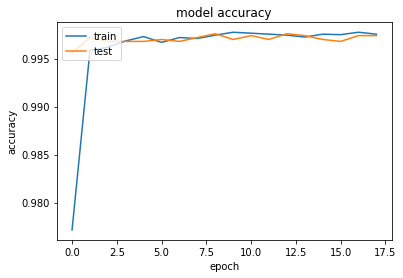

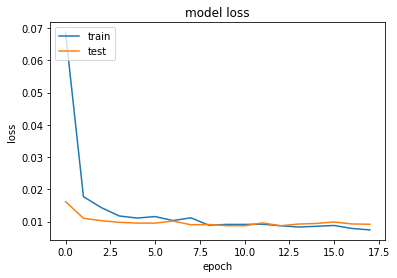

In [24]:
plot_history(history)

## 预测测试集

In [25]:
model.load_weights('top_multimodel_final.h5')

In [26]:
y_pred = model.predict(X_test, verbose=1)

12500/12500 [==============================] - 1s 103us/step


In [27]:
y_pred_clip = y_pred.clip(min=0.005, max=0.995)

In [28]:
df = pd.read_csv("sampleSubmission.csv")

gen = ImageDataGenerator()
test_generator = gen.flow_from_directory("test", (299, 299), shuffle=False, 
                                         batch_size=16, class_mode=None)

for i, fname in enumerate(test_generator.filenames):
    index = int(fname[fname.rfind('/')+1:fname.rfind('.')])
    df.loc[index-1, ['label']] = y_pred_clip[i]

df.to_csv('pred.csv', index=None)
df.head(10)

Found 12500 images belonging to 1 classes.


,id,label
0,1,0.995
1,2,0.995
2,3,0.995
3,4,0.995
4,5,0.005
5,6,0.005
6,7,0.005
7,8,0.005
8,9,0.005
9,10,0.005
